### Jupyter notebook contains a solutions from Chapter VI — Linear Model Selection from the book "Introduction To Statistical Learning" in a Python edition written by Daniela Witten, Trevor Hastie, Robert Tibshirani, Gareth James and Jonathan Taylor.

# Table of Contents

* [Exercise 6.6.8 (a)](#Exercise-6.6.8-a)
* [Exercise 6.6.8 (b)](#Exercise-6.6.8-b)
* [Exercise 6.6.8 (c)](#Exercise-6.6.8-c)
* [Exercise 6.6.8 (d)](#Exercise-6.6.8-d)
* [Exercise 6.6.8 (e)](#Exercise-6.6.8-e)
* [Exercise 6.6.8 (f)](#Exercise-6.6.8-f)
* [Exercise 6.6.9 (a)](#Exercise-6.6.9-a)
* [Exercise 6.6.9 (b)](#Exercise-6.6.9-b)
* [Exercise 6.6.9 (c)](#Exercise-6.6.9-c)
* [Exercise 6.6.9 (d)](#Exercise-6.6.9-d)
* [Exercise 6.6.9 (e)](#Exercise-6.6.9-e)
* [Exercise 6.6.9 (f)](#Exercise-6.6.9-f)
* [Exercise 6.6.9 (g)](#Exercise-6.6.9-g)
* [Exercise 6.6.10 (a)](#Exercise-6.6.10-a)
* [Exercise 6.6.10 (b)](#Exercise-6.6.10-b)
* [Exercise 6.6.10 (c)](#Exercise-6.6.10-c)
* [Exercise 6.6.10 (d)](#Exercise-6.6.10-d)
* [Exercise 6.6.10 (e)](#Exercise-6.6.10-e)
* [Exercise 6.6.10 (f)](#Exercise-6.6.10-f)
* [Exercise 6.6.10 (g)](#Exercise-6.6.10-g)
* [Exercise 6.6.11 (a)](#Exercise-6.6.11-a)
* [Exercise 6.6.11 (b)](#Exercise-6.6.11-b)
* [Exercise 6.6.11 (c)](#Exercise-6.6.11-c)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

from itertools import combinations
from functools import partial

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, ElasticNetCV, Lasso, LassoCV, RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import cross_validate, ShuffleSplit, KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.models import Stepwise, sklearn_selected, sklearn_selection_path 
from ISLP.models import poly
from l0bnb import fit_path


scaler = StandardScaler()

### Exercise 6.6.8 

In this exercise, we will generate simulates data, and will then use this data to perform forward and backward stepwise selection.

#### Exercise 6.6.8 a

Create a random number generator and use its `normal()` method to generate a predictor $X$ of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.

In [2]:
X = np.random.normal(size=100)
epsilon = np.random.normal(size=100)

#### Exercise 6.6.8 b

Generate a response vector $Y$ of length $n = 100$ according to the model

$$
Y = \beta_0 + \beta_1X + \beta_2X^{2} + \beta_3X^{3} + \epsilon
$$

In [3]:
beta_0, beta_1, beta_2, beta_3 = 15, 5, -3, 2

Y = beta_0 + beta_1 * X + beta_2 * np.square(X) + beta_3 * np.power(X, 3) + epsilon

#### Exercise 6.6.8 c

Use forward stepwise selection in order to select a model containing the predictors $X, X^{2}, \dots, X^{10}$. What is the model obtained
according to $C_p$? Report the coefficients of the model obtained.

In [4]:
def nCp(sigma_2, estimator, X, y):
    n, p = X.shape
    y_hat = estimator.predict(X)
    RSS = np.sum(np.square(y - y_hat))
    return -(RSS + 2 * p * sigma_2) / n

In [5]:
X_poly = PolynomialFeatures(degree=10, include_bias=False)

In [6]:
preds = X_poly.fit_transform(X.reshape(-1, 1))

In [7]:
data = pd.DataFrame(preds)
data.columns = ['x' + str(i) for i in range(1, 11)]

In [8]:
data['y'] = Y

In [9]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.399617,0.159694,0.063816,0.025502,0.010191,0.004073,0.001627,0.000650,0.000260,0.000104,16.138826
1,0.932998,0.870486,0.812162,0.757746,0.706976,0.659607,0.615413,0.574179,0.535708,0.499815,19.370027
2,-1.051131,1.104877,-1.161370,1.220752,-1.283171,1.348781,-1.417745,1.490236,-1.566433,1.646527,2.055220
3,2.119025,4.490269,9.514994,20.162515,42.724882,90.535112,191.846207,406.526997,861.441055,1825.415524,30.437328
4,-0.634067,0.402042,-0.254921,0.161637,-0.102489,0.064985,-0.041205,0.026127,-0.016566,0.010504,10.288292


In [10]:
def forward_stepwise_selection(data, target, criterion):
    selected_features = []
    adjusted_r2, cps, bics = [], [], []
    remaining_features = list(range(len([col for col in data.columns if col != target])))
    total_features = []
    models = []

    while remaining_features:

        best_score = -np.inf
        best_feature = None

        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_train_sub = data.iloc[:, current_features]

            X_train_design = sm.add_constant(X_train_sub)
            model = sm.OLS(data[target], X_train_design).fit()
            negCp = partial(criterion, model.scale)
            score = negCp(model, X_train_design, data[target])
            
            if score > best_score:
                best_score = score
                best_feature = feature
                best_model = model

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        cps.append(-best_score)
        adjusted_r2.append(best_model.rsquared_adj)
        bics.append(best_model.bic)
        total_features.append(selected_features.copy())
        models.append(best_model.params.values)
        
    return pd.DataFrame({'n_features': list(map(len, total_features)), 
                         'adj_R_squared': adjusted_r2, 'Cp': cps, 'BIC': bics, 
                         'features': [data.columns[i].values for i in total_features],
                         'model_coeffs': models
                        })

In [11]:
forward_best_features = forward_stepwise_selection(data, 'y', nCp)

In [12]:
forward_best_features

,n_features,adj_R_squared,Cp,BIC,features,model_coeffs
0,1,0.951732,26.769633,617.724328,[x3],"[12.076891808475885, 3.010702418127681]"
1,2,0.973316,14.944049,562.032735,"[x3, x2]","[14.505384127676427, 2.7055474205685557, -1.98..."
2,3,0.997326,1.512085,335.553076,"[x3, x2, x1]","[15.036891617307095, 2.020539704333503, -3.017..."
3,4,0.997315,1.532682,339.507109,"[x3, x2, x1, x4]","[15.096274873604155, 2.0699627768834095, -3.13..."
4,5,0.997366,1.518360,341.167347,"[x3, x2, x1, x4, x6]","[15.226623511941042, 2.035899203800227, -3.554..."
5,6,0.997345,1.544549,345.474150,"[x3, x2, x1, x4, x6, x5]","[15.23659290587996, 2.1857295336517053, -3.590..."
6,7,0.997320,1.573664,349.935477,"[x3, x2, x1, x4, x6, x5, x7]","[15.206716473215463, 2.277306431495015, -3.416..."
7,8,0.997341,1.576129,352.682577,"[x3, x2, x1, x4, x6, x5, x7, x8]","[15.301246207910024, 3.137511197604807, -4.034..."
8,9,0.997377,1.568894,354.809406,"[x3, x2, x1, x4, x6, x5, x7, x8, x10]","[15.44227459455763, 2.537848165610022, -5.4338..."
9,10,0.997393,1.573642,357.694475,"[x3, x2, x1, x4, x6, x5, x7, x8, x10, x9]","[15.518578182120304, 4.218817577214825, -6.246..."


In [13]:
def plot_selection_method_results(data):
    fig, ax = plt.subplots(3, 1, figsize=(5, 15))
    measures = ['Cp', 'BIC', 'adj_R_squared']
    
    for index, metric in enumerate(measures):
        ax[index].plot(data['n_features'], data[metric], marker='o')
        ax[index].axhline(y=data[metric].min() if metric != 'adj_R_squared' else data[metric].max(), linestyle='dashed', linewidth=0.5, color='black')
        ax[index].axvline(x =data.sort_values(metric,ascending=True)['n_features'].values[0 if metric != 'adj_R_squared' else -1], color='black', linestyle='dashed', linewidth=0.5)
        ax[index].set_title(f'{metric}')
        ax[index].set_xlabel('Number of features')
        ax[index].set_ylabel(f'{metric} values')


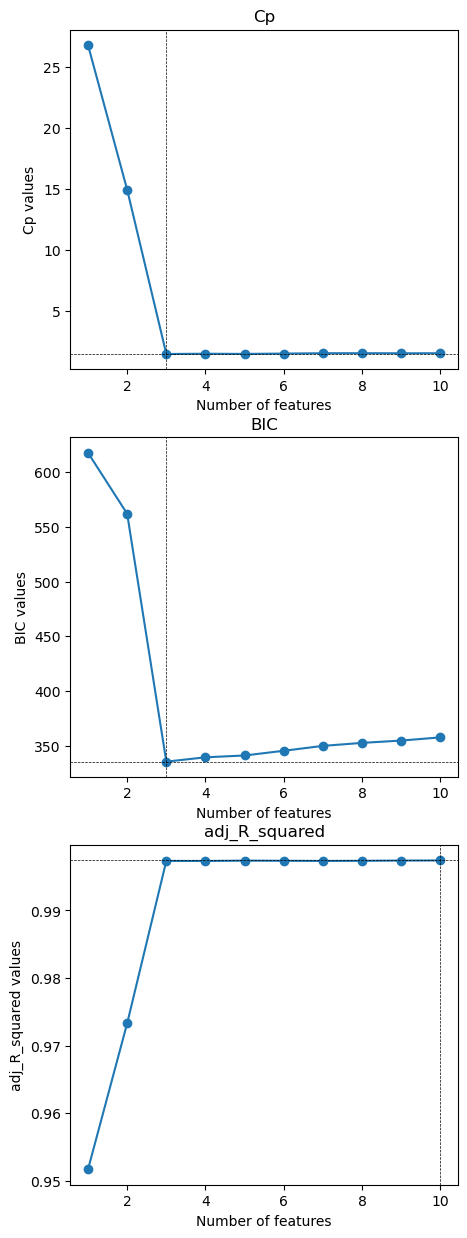

In [14]:
plot_selection_method_results(forward_best_features)

In [15]:
forward_best_features[forward_best_features.Cp == forward_best_features.Cp.min()].model_coeffs.values

array([array([15.03689162,  2.0205397 , -3.01764534,  5.06248667])],
      dtype=object)

#### Exercise 6.6.8

Repeat [(c)](#Exercise-6.6.8-c), using backwards stepwise selection. How does your answer compare to the results in [(c)](#Exercise-6.6.8-c)?

__Answer__:

- The results does not might vary to much, both methods picked the same amount of features and also the same feautres with a distinction of the order of that features.

In [16]:
def backward_stepwise_selection(data, target, criterion):
    selected_features = list(range(len([col for col in data.columns if col != target])))
    adjusted_r2, cps, bics = [], [], []
    total_features = []
    models = []

    while len(selected_features) > 1:

        best_score = -np.inf
        worst_feature = None

        for feature in selected_features:
            current_features = selected_features.copy()
            current_features.remove(feature)
            X_train_sub = data.iloc[:, current_features]

            X_train_design = sm.add_constant(X_train_sub)
            model = sm.OLS(data[target], X_train_design).fit()
            negCp = partial(criterion, model.scale)
            score = negCp(model, X_train_design, data[target])

            if score > best_score:
                best_score = score
                worst_feature = feature
                best_model = model

        selected_features.remove(worst_feature)
        cps.append(-best_score)
        adjusted_r2.append(best_model.rsquared_adj)
        bics.append(best_model.bic)
        total_features.append(selected_features.copy())
        models.append(best_model.params.values)
        
    selected_features = [0]
    X_train_sub = data.iloc[:, selected_features]

    X_train_design = sm.add_constant(X_train_sub)
    model = sm.OLS(data[target], X_train_design).fit()
    negCp = partial(criterion, model.scale)
    score = negCp(model, X_train_design, data[target])
    cps.append(-score)
    adjusted_r2.append(model.rsquared_adj)
    bics.append(model.bic)
    total_features.append(selected_features)
    models.append(model.params.values)

    return pd.DataFrame({'n_features': list(map(len, total_features)), 
                         'adj_R_squared': adjusted_r2, 'Cp': cps, 'BIC': bics, 
                         'features': [data.columns[i].values for i in total_features],
                         'model_coeffs': models
                        })


In [17]:
backward_best_features = backward_stepwise_selection(data, 'y', nCp)

In [18]:
backward_best_features.head()

,n_features,adj_R_squared,Cp,BIC,features,model_coeffs
0,9,0.997377,1.568894,354.809406,"[x1, x2, x3, x4, x5, x6, x7, x8, x10]","[15.442274594586166, 4.68887216936668, -5.4338..."
1,8,0.997399,1.541631,350.469514,"[x1, x2, x3, x4, x6, x7, x8, x10]","[15.445030326179218, 4.896402890988008, -5.526..."
2,7,0.997416,1.517351,346.291424,"[x1, x2, x3, x4, x6, x8, x10]","[15.42344980951955, 4.778305537215743, -5.2751..."
3,6,0.997338,1.548857,345.752694,"[x1, x2, x3, x4, x8, x10]","[15.19988516704224, 4.980050884131021, -3.4070..."
4,5,0.997366,1.518369,341.168000,"[x1, x2, x3, x4, x10]","[15.212057231569677, 4.996209239829323, -3.470..."


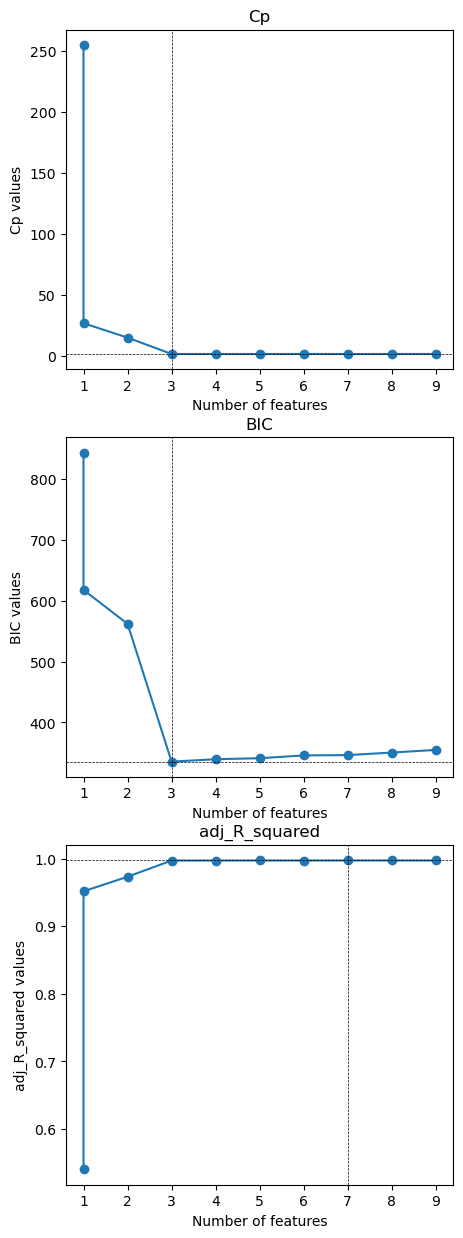

In [19]:
plot_selection_method_results(backward_best_features)

In [20]:
backward_best_features.loc[backward_best_features['Cp'] == backward_best_features['Cp'].min()].model_coeffs.values

array([array([15.03689162,  5.06248667, -3.01764534,  2.0205397 ])],
      dtype=object)

#### Exercise 6.6.8 e

Now fit a lasso model to the simulated data, again using, $X, X^{2}, \dots,X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross validation error as function of $\lambda$. Report the resulting coefficients estimates, and discuss the results obtained.

In [21]:
K = 5
kfold = KFold(K, random_state=0, shuffle=True)
lasso_cv = ElasticNetCV(l1_ratio=1, alphas=np.logspace(-4, 4, 100), cv=kfold)
pipe_cv = Pipeline(steps=[('scaler', scaler), ('lasso', lasso_cv)])
pipe_cv.fit(preds, Y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03,...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=1))])

In [22]:
tuned_lasso_cv = pipe_cv.named_steps['lasso']
tuned_lasso_cv.alpha_

0.015199110829529346

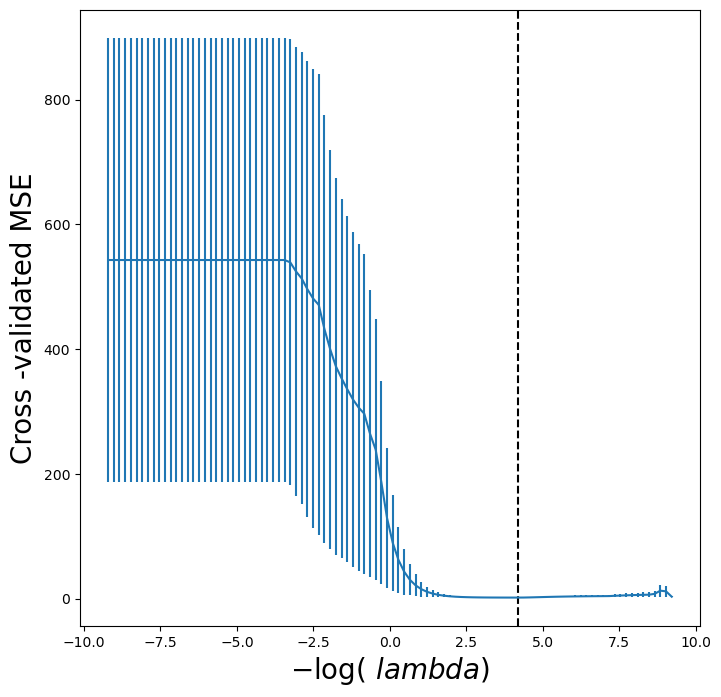

In [23]:
lasso_cv, ax = plt.subplots(figsize =(8,8))
ax.errorbar(-np.log(tuned_lasso_cv.alphas_), tuned_lasso_cv.mse_path_.mean(1), yerr=tuned_lasso_cv.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso_cv.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\ lambda)$', fontsize = 20)
ax.set_ylabel('Cross -validated MSE', fontsize = 20);

In [24]:
X_scaled = scaler.fit_transform(preds)

In [25]:
lambdas, soln_array = Lasso.path(X_scaled, Y, l1_ratio=1, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=range(X_scaled.shape[1]), index=-np.log(lambdas))

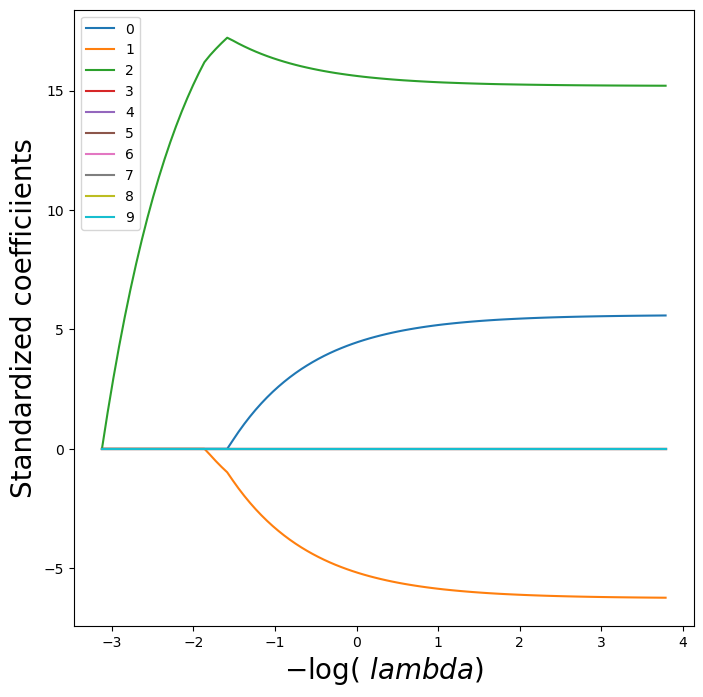

In [26]:
path_fig, ax = plt.subplots(figsize=(8 ,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\ lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [27]:
tuned_lasso_cv.coef_

array([ 5.59044148, -6.24103823, 15.20358404,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ])

#### Exercise 6.6.8 f

Now generate a response vector $Y$ according to the model

$$
Y = \beta_0 + \beta_7X^{7} + \epsilon
$$

and perform forward stepwise selection and the lasso. Discuss the results obtained.

__Answer__:

- with a model $Y = \beta_0 + \beta_7 \cdot X^{7} + \epsilon$, the only one feature is associated with a response variable, the forward selection method recognized this association, since the first row of the found feature is $X^{7}$,
- The plots of the forward stepwise selection suggests huge overfitting of all models, $C_p, \text{BIC}$ increases, instaed of decreasing, it suggests very high variance, since the model tries to fit all powers of predictors from $1$ to $10$, whereas in reality, only $7th$ power is associated with response variable $y$,
- Lasso finds that trend as well, we see that model coefficients of the Lasso Regression, zeroed out all $\beta$s with an exception of $\beta_7$ which in fact is associated with predictor and $\beta_8, \beta_9, \beta_10$ which have a small values,
- the estimated values for real $\beta_0 = 10$ and $\beta_1 = 5$ of the lasso model: $\hat{\beta_0} = 7.96$ and $\hat{\beta_7} = 4.93$ suggests close estimation to the real values of $\beta$.

In [28]:
beta_0, beta_7 = 10, 5
Y = beta_0 + beta_7 * np.power(X, 7) + epsilon

In [29]:
data['y'] = Y

In [30]:
forward_best_subset = forward_stepwise_selection(data, 'y', nCp)

In [31]:
forward_best_subset

,n_features,adj_R_squared,Cp,BIC,features,model_coeffs
0,1,1.0,1.468291,327.407416,[x7],"[10.038923475274267, 5.000108001864551]"
1,2,1.0,1.481459,330.904148,"[x7, x6]","[9.992256366311468, 5.000905053170066, 0.00324..."
2,3,1.0,1.476628,333.180207,"[x7, x6, x2]","[10.149469751192115, 5.002575851327314, 0.0108..."
3,4,1.0,1.495282,337.036679,"[x7, x6, x2, x4]","[10.211717049203552, 5.0015066108793045, 0.001..."
4,5,1.0,1.517250,341.094216,"[x7, x6, x2, x4, x3]","[10.23660560559263, 4.998918548863951, -0.0135..."
5,6,1.0,1.546462,345.597923,"[x7, x6, x2, x4, x3, x5]","[10.212226019827, 5.001459238403985, -0.003926..."
6,7,1.0,1.568016,349.575907,"[x7, x6, x2, x4, x3, x5, x8]","[10.261772879418064, 5.02014036492692, -0.0745..."
7,8,1.0,1.543161,350.568716,"[x7, x6, x2, x4, x3, x5, x8, x10]","[10.443341355339797, 5.006567455861266, -0.950..."
8,9,1.0,1.566849,354.679028,"[x7, x6, x2, x4, x3, x5, x8, x10, x9]","[10.477391302363948, 5.167825513454872, -1.293..."
9,10,1.0,1.573642,357.694475,"[x7, x6, x2, x4, x3, x5, x8, x10, x9, x1]","[10.518578182114924, 5.416765870375585, -1.555..."


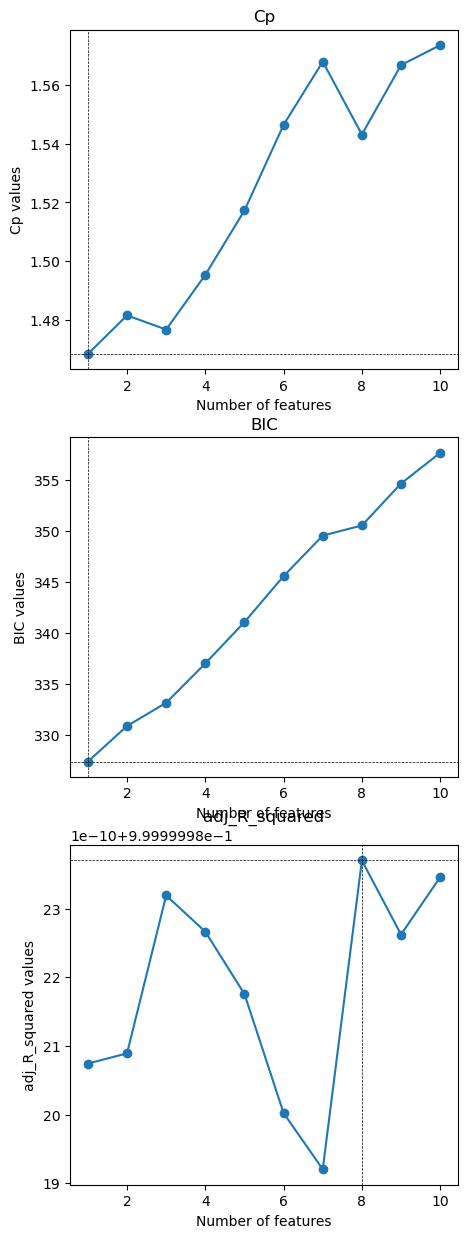

In [32]:
plot_selection_method_results(forward_best_subset)

In [33]:
lasso_cv = LassoCV(alphas=np.logspace(-5, 3, 100), max_iter=100000)
lasso_cv.fit(data.loc[:, data.columns.drop('y')], Y)

LassoCV(alphas=array([1.00000000e-05, 1.20450354e-05, 1.45082878e-05, 1.74752840e-05,
       2.10490414e-05, 2.53536449e-05, 3.05385551e-05, 3.67837977e-05,
       4.43062146e-05, 5.33669923e-05, 6.42807312e-05, 7.74263683e-05,
       9.32603347e-05, 1.12332403e-04, 1.35304777e-04, 1.62975083e-04,
       1.96304065e-04, 2.36448941e-04, 2.84803587e-04, 3.43046929e-04,
       4.13201240e-04, 4.97702356e-0...
       1.38488637e+01, 1.66810054e+01, 2.00923300e+01, 2.42012826e+01,
       2.91505306e+01, 3.51119173e+01, 4.22924287e+01, 5.09413801e+01,
       6.13590727e+01, 7.39072203e+01, 8.90215085e+01, 1.07226722e+02,
       1.29154967e+02, 1.55567614e+02, 1.87381742e+02, 2.25701972e+02,
       2.71858824e+02, 3.27454916e+02, 3.94420606e+02, 4.75081016e+02,
       5.72236766e+02, 6.89261210e+02, 8.30217568e+02, 1.00000000e+03]),
        max_iter=100000)

In [34]:
lasso_cv.intercept_, lasso_cv.coef_

(24.098194936601203,
 array([ 5.09305084e+01, -7.68463122e+01, -7.92327204e+01,  4.26919272e+01,
         3.10398166e+01, -4.76485748e+00,  1.24961734e+00, -1.62281058e-01,
         3.62678092e-02, -4.29422318e-03]))

In [35]:
pd.Series(np.hstack([lasso_cv.intercept_,lasso_cv.coef_]),index = ['Intercept']+['X' + str(i) for i in range(1,11)])

Intercept    24.098195
X1           50.930508
X2          -76.846312
X3          -79.232720
X4           42.691927
X5           31.039817
X6           -4.764857
X7            1.249617
X8           -0.162281
X9            0.036268
X10          -0.004294
dtype: float64

### Exercise 6.6.9 

In this exercise, we will predict the number of applications received using the other variables in the `College` data set.

#### Exercise 6.6.9 a

Split the data set into a training and test set.

In [36]:
college_data = load_data('College')
le = LabelEncoder()
college_data['Private'] = le.fit_transform(college_data['Private'])
X = college_data.loc[:, college_data.columns.drop('Apps')]
y = college_data['Apps']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Exercise 6.6.9 b

Fit a linear model using least squares on the training set, and report the test error obtained.

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [39]:
test_mse_ls = mean_squared_error(y_test, y_pred)
test_mse_ls

1176083.9778028482

In [40]:
test_rmse_ls = np.sqrt(test_mse_ls)
test_rmse_ls

1084.4740558458964

#### Exercise 6.6.9 c

Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.

In [41]:
validation = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
ridge_cv = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=validation, )

In [42]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)


In [43]:
ridge_cv.fit(X_std, y)

RidgeCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None))

In [44]:
optimal_alpha = ridge_cv.alpha_
optimal_alpha

17.886495290574352

In [45]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [46]:
ridge = Ridge(alpha=optimal_alpha)
ridge.fit(X_train_std, y_train)

Ridge(alpha=17.886495290574352)

In [47]:
y_pred = ridge.predict(X_test_std)

In [48]:
ridge_test_mse = mean_squared_error(y_test, y_pred)
ridge_test_mse

1111801.8490036551

In [49]:
ridge_test_rmse = np.sqrt(ridge_test_mse)
ridge_test_rmse

1054.4201482348747

#### Exercise 6.6.9 d

Fit a lasso model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with the num-
ber of non-zero coefficient estimates.

In [50]:
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=validation,)
lasso_cv.fit(X, y)

LassoCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None))

In [51]:
lasso_optimal_alpha = lasso_cv.alpha_
lasso_optimal_alpha

2257.0197196339213

In [52]:
lasso = Lasso(alpha=lasso_optimal_alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=2257.0197196339213)

In [53]:
y_hat = lasso.predict(X_test)

In [54]:
lasso_test_mse = mean_squared_error(y_test, y_hat)
lasso_test_mse

1122032.0550546928

In [55]:
lasso_test_rmse = np.sqrt(lasso_test_mse)
lasso_test_rmse

1059.2601451271037

In [56]:
lasso.coef_

array([-0.00000000e+00,  1.58836493e+00, -8.29792341e-01,  2.20287423e+01,
        0.00000000e+00,  7.24709214e-02,  1.73895761e-02, -8.01065988e-02,
        1.33962958e-01,  5.58469090e-03, -1.67997844e-02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.57048799e-02,
        0.00000000e+00])

#### Exercise 6.6.9 e

Fit a PCR model on the training set, with $M$ chosen by cross validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.

In [57]:
regression = LinearRegression()
scaler = StandardScaler()
pca = PCA(n_components=2)
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('regression',  regression)])
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('regression', LinearRegression())])

In [58]:
pipe.named_steps['regression'].coef_

array([ 253.66931688, 1558.60007943])

In [59]:
X.shape[1]

17

In [60]:
param_grid = {
    'pca__n_components': range(1, X.shape[1] + 1),
}
K = 5
kfold = KFold(K, random_state=0, shuffle=True)
grid = GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('regression', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 18)},
             scoring='neg_mean_squared_error')

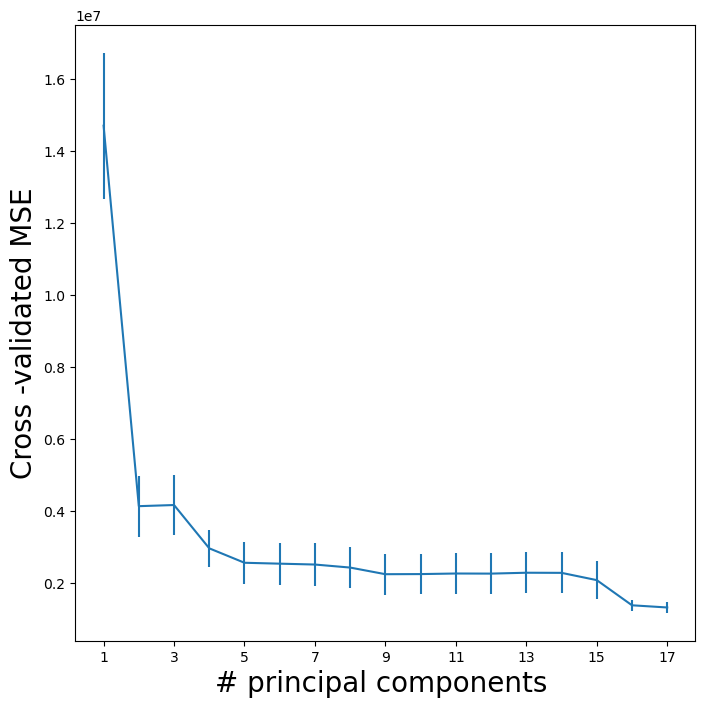

In [61]:
pcr_fig, ax = plt.subplots(figsize =(8 ,8))
n_comp = param_grid['pca__n_components'] 
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components ', fontsize=20)
ax.set_xticks(n_comp[::2]);

In [62]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.31669858, 0.25627714])

In [63]:
test_mse_pcr_cv = -grid.cv_results_['mean_test_score'].mean()
test_mse_pcr_cv

3196477.6711712354

In [64]:
np.sqrt(test_mse_pcr_cv)

1787.8695900907412

In [65]:
scaler = StandardScaler()  # Fitting PCR with M = 10
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA(n_components=10)
X_train_dcmp = pca.fit_transform(X_train_std)
X_test_dcmp = pca.transform(X_test_std)

pcr = LinearRegression()
pcr.fit(X_train_dcmp, y_train)

y_hat = pcr.predict(X_test_dcmp)

pcr_test_mse = mean_squared_error(y_test, y_hat)
pcr_test_mse


1633711.7120079682

In [66]:
pcr_test_rmse = np.sqrt(pcr_test_mse)
pcr_test_rmse

1278.1673255125747

#### Exercise 6.6.9 f

Fit a PLS model on the training set, with $M$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.

In [67]:
param_grid = {'n_components': range(1, X.shape[1] + 1)}
pls = PLSRegression(n_components=2, scale=True)
grid = GridSearchCV(pls, param_grid, cv=kfold, scoring='neg_mean_squared_error')

In [68]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 18)},
             scoring='neg_mean_squared_error')

In [69]:
pls_test_mse_grid_cv = -grid.cv_results_['mean_test_score'].mean()
pls_test_mse_grid_cv

1587492.2344234933

In [70]:
pls_test_rmse_grid_cv = np.sqrt(pls_test_mse_grid_cv)
pls_test_rmse_grid_cv

1259.9572351566117

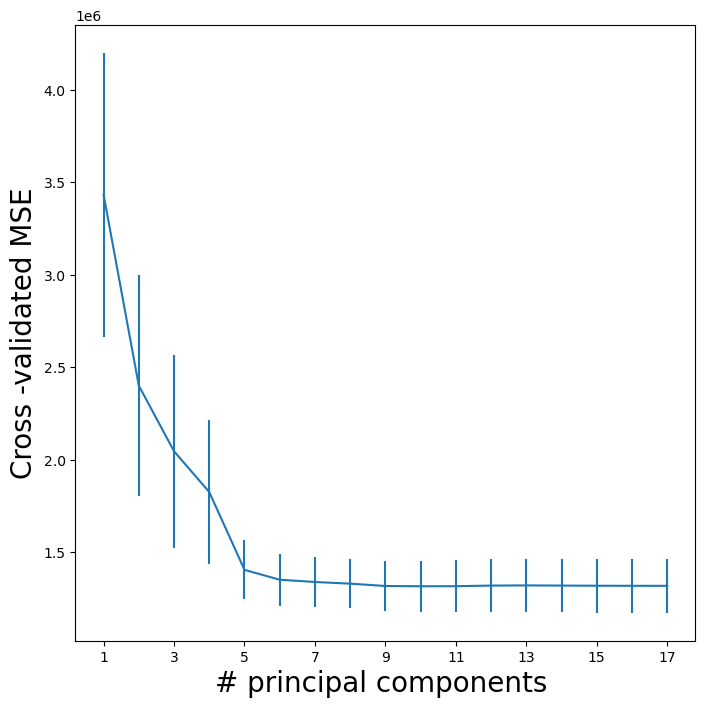

In [71]:
pls_fig, ax = plt.subplots(figsize=(8 ,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize =20)
ax.set_xlabel('# principal components ', fontsize =20)
ax.set_xticks(n_comp[::2]);

In [72]:
pls = PLSRegression(n_components=5, scale=True)
pls.fit(X_train, y_train)

PLSRegression(n_components=5)

In [73]:
y_hat = pls.predict(X_test)

In [74]:
pls_test_mse = mean_squared_error(y_test, y_hat)
pls_test_mse

1106991.1725039529

In [75]:
pls_test_rmse = np.sqrt(pls_test_mse)
pls_test_rmse

1052.1364799796427

#### Exercise 6.6.9 g

Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much
difference among the test errors resulting from these five approaches?

__Answer__:

### Interpretation of Results:

1. **Least Squares Regression:**
   - MSE: 1176083.98
   - RMSE: 1084.47

2. **Ridge Regression:**
   - MSE: 1111801.85
   - RMSE: 1054.42

3. **Lasso Regression:**
   - MSE: 1122032.06
   - RMSE: 1059.26

4. **PCR (Principal Component Regression):**
   - MSE: 1633711.71
   - RMSE: 1278.17

5. **PLS (Partial Least Squares):**
   - MSE: 1106991.17
   - RMSE: 1052.14


As we can see, all the methods have a similar test MSE. The lowest one achieved PLS method, which would indicate that this method will give the most accurate prediction among all these methods. Ridge and PLS have also the lowest RMSE. The average number of application for each college is around $3001$ applications. Our the best method, on average, produces prediction error rate by $35\%$.


In [76]:
mse_values = [1176083.98, 1111801.85, 1122032.06, 1633711.71, 1106991.17]
mse_variance = np.var(mse_values)
print(f"Variance of MSE: {mse_variance}")

rmse_values = [1084.47, 1054.42, 1059.26, 1278.17, 1052.14]
rmse_variance = np.var(rmse_values)
print(f"Variance of RMSE: {rmse_variance}")

Variance of MSE: 41329811184.38417
Variance of RMSE: 7570.319816000001


In [77]:
average_apps = college_data['Apps'].mean()
average_apps

3001.6383526383524

In [78]:
min(rmse_values) / average_apps

0.3505219071695295

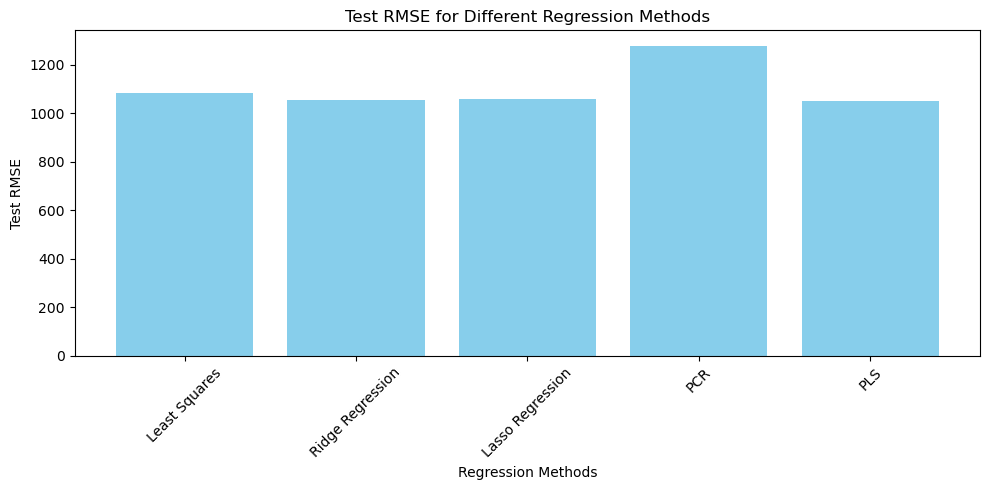

In [79]:
methods = ['Least Squares', 'Ridge Regression', 'Lasso Regression', 'PCR', 'PLS']
rmse_values = [1084.47, 1054.42, 1059.26, 1278.17, 1052.14] 

plt.figure(figsize=(10, 5))
plt.bar(methods, rmse_values, color='skyblue')
plt.xlabel('Regression Methods')
plt.ylabel('Test RMSE')
plt.title('Test RMSE for Different Regression Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();


#### Exercise 6.6.10

We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

#### Exercise 6.6.10

Generate a data set with $p = 20$ features, $n = 1000$ observations, and an associated quantative response vector, generated according to the model

$$
Y = X\beta + \epsilon
$$

Where $\beta$ has some elements that are exactly equal to 0.

In [80]:
X = np.random.normal(size=(1000, 20))
epsilon = np.random.normal(size=(1000, 1))
beta = np.random.randint(-5, 10, size=(20,))
num_zero_elements = 8
zero_indices = np.random.choice(np.prod(*beta.shape), num_zero_elements, replace=False)
zero_indices = np.unravel_index(zero_indices, beta.shape)
beta = beta.copy()
beta[zero_indices] = 0

In [81]:
Y = X @ beta.reshape(-1, 1) + epsilon

#### Exercise 6.6.10 b

Split your data set into a training set containing 100 observations, and a test set containing 900 observations.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=0, shuffle=True)

#### Exercise 6.6.10 c

Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

In [83]:
def best_subset_selection(X_train, X_test, y_train, y_test):
    training_mses = []
    testing_mses = []
    selected_features = []
    best_models = []
    p = X.shape[1]
    k = 1
    while k <= p:
        
        feature_combinations = list(combinations(range(p), r=k))
        train_mses, columns = [], []
        test_mses = []
        models = []
        for feature_index in feature_combinations:
            model = LinearRegression(n_jobs=-1)
            fitted_model = model.fit(X_train[:, feature_index], y_train)
            y_hat = fitted_model.predict(X_train[:, feature_index])
            train_mses.append(mean_squared_error(y_train, y_hat))
            y_hat = fitted_model.predict(X_test[:, feature_index])
            test_mses.append(mean_squared_error(y_test, y_hat))
            columns.append(feature_index)
            models.append(fitted_model)
            
        train_index = train_mses.index(min(train_mses))
        test_index = test_mses.index(min(test_mses))
        
        the_best_train_mse = min(train_mses)
        the_best_test_mse = min(test_mses)
        
        the_best_features = columns[test_mses.index(the_best_test_mse)]
        best_models.append(models[test_mses.index(the_best_test_mse)])
        
        training_mses.append(the_best_train_mse)
        testing_mses.append(the_best_test_mse)
        selected_features.append(the_best_features)
        
        k += 1
        print(f'Starting best subset at: {k}')
        
    return training_mses, testing_mses, selected_features, best_models

In [84]:
training_mses, test_mses, selected_features, best_models = best_subset_selection(X_train, X_test, y_train, y_test)

Starting best subset at: 2
Starting best subset at: 3
Starting best subset at: 4
Starting best subset at: 5
Starting best subset at: 6
Starting best subset at: 7
Starting best subset at: 8
Starting best subset at: 9
Starting best subset at: 10
Starting best subset at: 11
Starting best subset at: 12
Starting best subset at: 13
Starting best subset at: 14
Starting best subset at: 15
Starting best subset at: 16
Starting best subset at: 17
Starting best subset at: 18
Starting best subset at: 19
Starting best subset at: 20
Starting best subset at: 21


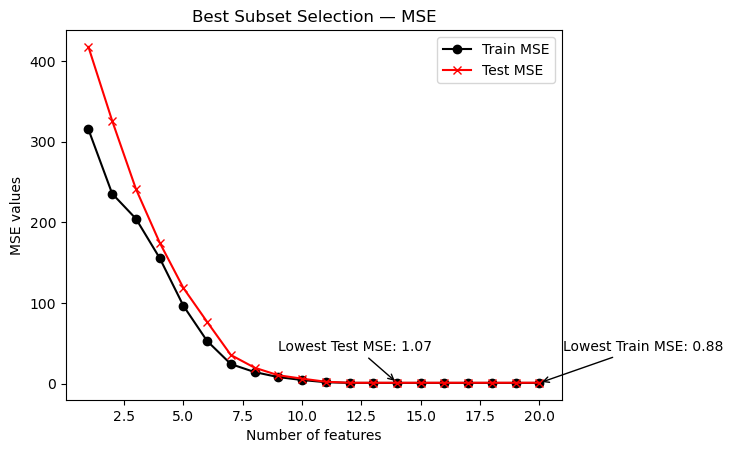

In [85]:
plt.title('Best Subset Selection — MSE')
plt.plot(list(map(len, selected_features)), training_mses, marker='o', color='black', label='Train MSE');
plt.plot(list(map(len, selected_features)), test_mses, marker='x', color='red', label='Test MSE')
plt.ylabel('MSE values')
plt.xlabel('Number of features')
plt.legend()


min_test_mse_idx = test_mses.index(min(test_mses))
min_train_mse_idx = training_mses.index(min(training_mses))

plt.annotate(f'Lowest Test MSE: {min(test_mses):.2f}', 
             xy=(len(selected_features[min_test_mse_idx]), test_mses[min_test_mse_idx]), 
             xytext=(len(selected_features[min_test_mse_idx]) - 5, test_mses[min_test_mse_idx] + 40),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(f'Lowest Train MSE: {min(training_mses):.2f}', 
             xy=(len(selected_features[min_train_mse_idx]), training_mses[min_train_mse_idx]), 
             xytext=(len(selected_features[min_train_mse_idx]) + 1, training_mses[min_train_mse_idx] + 40),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show();


#### Exercise 6.6.10 d

Plot the test MSE associated with the best model of each size.

The test MSE has been plotted on the above graph.

#### Exercise 6.6.10 e

For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

__Answer__:

- the best test MSE is $0.9992$ for 10 features.

In [86]:
the_best_mse = min(test_mses)
the_best_mse

1.0745775808287232

In [87]:
features = selected_features[test_mses.index(the_best_mse)]
features

(0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 14, 16, 18, 19)

In [88]:
len(features)

14

#### Exercise 6.6.10 f

How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.

__Answer__:

- estimated coefficients with the lowest test set error are not close to the true one. The reason might be high bias due to the split of the data: $90\%$ of whole data are used as test set, whereas $10\%$ are used as training set. The model in this way, may not capture the real relationship.

In [89]:
beta

array([ 0,  9,  9,  0,  2, -2,  7,  4, -3, -1,  0,  6,  0,  0,  9,  0,  0,
        0,  7,  8])

In [90]:
best_models[test_mses.index(min(test_mses))].coef_

array([[ 0.0420032 ,  8.98644693,  8.97141316,  2.06835847, -1.88056694,
         6.99383073,  3.92960267, -2.97024628, -0.89712499,  5.8409484 ,
         9.1059533 , -0.06412954,  7.11506402,  8.18520146]])

#### Exercise 6.6.10 g

Create a plot displaying $\sqrt{\sum_{j=1}^p\left(\beta_j - \hat{\beta}^{r}_j \right)^{2}}$ for a range of values of $r$, where $\hat{\beta}^{r}_j$ is the $j$th coefficient estimate for the best model containing $r$ coefficients. Comment on what you observe. How does this compare to the test MSE plot from [(d)](#Exercise-6.6.10-d)?

__Answer__:

- The plot suggests, that the lowest difference between real coefficient values and esimated one is above 15 features.
- With an increasing $r$, the estimates gets better and better.

In [91]:
data=[model.coef_ for model in best_models]

In [92]:
max_length = max(len(subarray[0]) for subarray in data)
padded_data = [np.pad(subarray[0], (0, max_length - len(subarray[0])) , mode='constant') for subarray in data]
result = np.vstack(padded_data)

In [93]:
sqrt_diff = np.sqrt(np.sum(np.square(beta - result), axis=1))

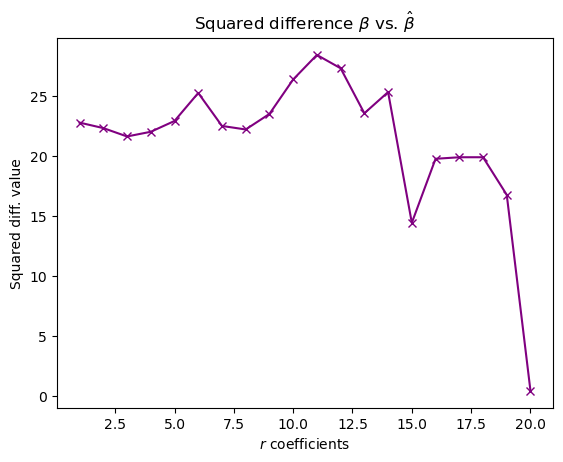

In [94]:
plt.title('Squared difference $\\beta$ vs. $\\hat{\\beta}$')
plt.plot([array.shape[1] for array in data], sqrt_diff, marker='x', color='purple');
plt.xlabel('$r$ coefficients')
plt.ylabel('Squared diff. value')
plt.show();

### Exercise 6.6.11

We will now try to predict per capita crime rate in the `Boston` data set.

#### Exercise 6.6.11 a

Try out some regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.

In [95]:
boston_data = load_data('Boston')

In [96]:
boston_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [97]:
boston_data.crim.mean()

3.613523557312254

In [98]:
X = boston_data.loc[:, boston_data.columns.drop('crim')]
y = boston_data['crim']

In [99]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [100]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [101]:
# First, creating the Ridge with Cross-Validation to find optimal alpha
K = 5
kfold = KFold(n_splits=K, random_state=0, shuffle=True)
alphas = np.logspace(-5, 4, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=kfold, scoring='neg_mean_squared_error',)

In [102]:
ridge_cv.fit(X_train_std, y_train)

RidgeCV(alphas=array([1.00000000e-05, 1.23284674e-05, 1.51991108e-05, 1.87381742e-05,
       2.31012970e-05, 2.84803587e-05, 3.51119173e-05, 4.32876128e-05,
       5.33669923e-05, 6.57933225e-05, 8.11130831e-05, 1.00000000e-04,
       1.23284674e-04, 1.51991108e-04, 1.87381742e-04, 2.31012970e-04,
       2.84803587e-04, 3.51119173e-04, 4.32876128e-04, 5.33669923e-04,
       6.57933225e-04, 8.11130831e-0...
       1.87381742e+02, 2.31012970e+02, 2.84803587e+02, 3.51119173e+02,
       4.32876128e+02, 5.33669923e+02, 6.57933225e+02, 8.11130831e+02,
       1.00000000e+03, 1.23284674e+03, 1.51991108e+03, 1.87381742e+03,
       2.31012970e+03, 2.84803587e+03, 3.51119173e+03, 4.32876128e+03,
       5.33669923e+03, 6.57933225e+03, 8.11130831e+03, 1.00000000e+04]),
        cv=KFold(n_splits=5, random_state=0, shuffle=True),
        scoring='neg_mean_squared_error')

In [103]:
ridge_optimal_alpha = ridge_cv.alpha_
ridge_optimal_alpha

8.111308307896872

In [104]:
ridge_y_hat = ridge_cv.predict(X_test_std)
ridge_test_mse_cv = mean_squared_error(y_test, ridge_y_hat)
ridge_test_mse_cv

61.18545479509455

In [105]:
ridge = Ridge(alpha=ridge_optimal_alpha)
ridge.fit(X_train_std, y_train)
ridge_y_hat = ridge.predict(X_test_std)
ridge_test_mse = mean_squared_error(y_test, ridge_y_hat)
ridge_test_mse

61.18545479509455

In [106]:
ridge_test_rmse = np.sqrt(ridge_test_mse)
ridge_test_rmse

7.822113192424062

In [107]:
ridge.coef_

array([ 0.81762707, -0.53493069, -0.21756829, -0.70767787,  0.76082876,
       -0.37119647, -1.73446427,  4.30191789, -0.05130438, -0.48740378,
        1.45303085, -1.78477678])

In [108]:
err_prediction_rate = boston_data.crim.mean() / ridge_test_rmse
err_prediction_rate

0.4619625756390298

In [109]:
lasso_cv = LassoCV(alphas=alphas, max_iter=10000, random_state=0, cv=kfold, n_jobs=-1)
lasso_cv = lasso_cv.fit(X_train, y_train)

In [110]:
lasso_optimal_alpha = lasso_cv.alpha_
lasso_optimal_alpha

0.2310129700083158

In [111]:
lasso_y_hat = lasso_cv.predict(X_test)
lasso_test_mse = mean_squared_error(y_test, lasso_y_hat)
lasso_test_mse

60.68167966284746

In [112]:
lasso_test_rmse = np.sqrt(lasso_test_mse)
lasso_test_rmse

7.789844649468143

In [113]:
lasso_prediction_err_rate = boston_data.crim.mean() / lasso_test_rmse
lasso_prediction_err_rate

0.4638762029174702

In [114]:
lasso_cv.coef_

array([ 0.03974928, -0.0834035 , -0.        , -0.        ,  0.05792214,
       -0.01025349, -0.62040538,  0.53486469, -0.00293246, -0.09870577,
        0.16561335, -0.13984272])

In [115]:
training_mses, test_mses, selected_features, best_models = best_subset_selection(X_train.values, X_test.values, y_train.values, y_test.values)

Starting best subset at: 2
Starting best subset at: 3
Starting best subset at: 4
Starting best subset at: 5
Starting best subset at: 6
Starting best subset at: 7
Starting best subset at: 8
Starting best subset at: 9
Starting best subset at: 10
Starting best subset at: 11
Starting best subset at: 12
Starting best subset at: 13


In [116]:
best_train_mse = min(training_mses)
best_test_mse = min(test_mses)

best_train_mse, best_test_mse

(35.88760222442699, 59.144929269707006)

In [117]:
best_features = selected_features[test_mses.index(best_test_mse)]
best_features

(0, 2, 3, 5, 6, 7, 9, 11)

In [118]:
lr = LinearRegression()
lr.fit(X_train.values[:, best_features], y_train)

LinearRegression()

In [119]:
lr.coef_

array([ 4.46493089e-02, -8.12455265e-01, -1.13538305e+01,  2.21204013e-03,
       -9.60962136e-01,  5.41600028e-01, -3.80836656e-01, -2.41587201e-01])

In [120]:
lr_y_hat = lr.predict(X_test.values[:, best_features])
lr_test_mse = mean_squared_error(y_test, lr_y_hat)
lr_test_mse

59.144929269707006

In [121]:
lr_test_rmse = np.sqrt(lr_test_mse)
lr_test_rmse

7.690574053327034

In [122]:
lr_test_err_rate = boston_data.crim.mean() / lr_test_rmse
lr_test_err_rate

0.46986395713191276

In [123]:
scaler = StandardScaler()
pca = PCA(n_components=2)
lr = LinearRegression()

PCR_pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('lr', lr)])
PCR_pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('lr', LinearRegression())])

In [124]:
pcr_y_hat = PCR_pipe.predict(X_test)
pcr_test_mse = mean_squared_error(y_test, pcr_y_hat)
pcr_test_mse

73.23674644906072

In [125]:
pcr_test_rmse = np.sqrt(pcr_test_mse)
pcr_test_rmse

8.55784706857167

In [126]:
param_grid = {
    'pca__n_components': range(1, X.shape[1] + 1),
}
K = 5
kfold = KFold(K, random_state=0, shuffle=True)
grid = GridSearchCV(PCR_pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('lr', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 13)},
             scoring='neg_mean_squared_error')

In [127]:
pcr_test_mse_cv = -grid.cv_results_['mean_test_score'].mean()
pcr_test_mse_cv

41.004951326220684

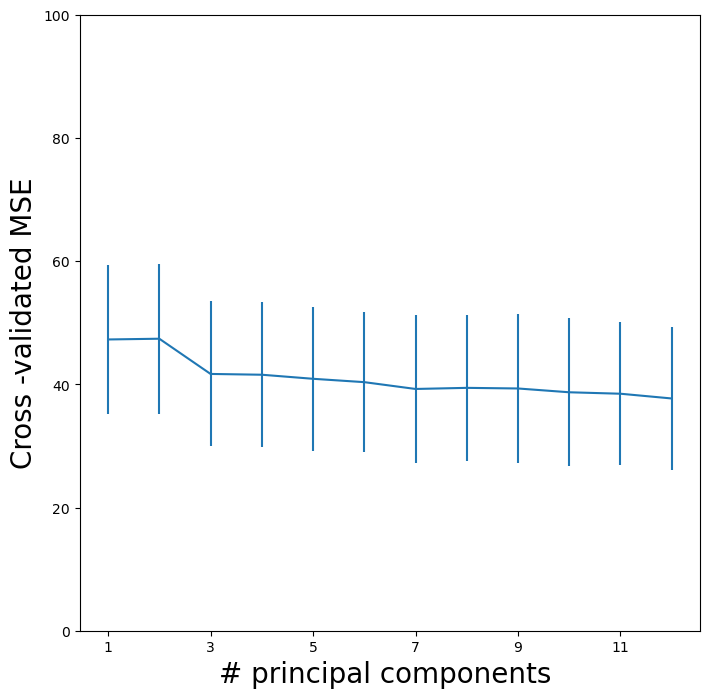

In [128]:
pcr_fig, ax = plt.subplots(figsize =(8 ,8))
n_comp = param_grid['pca__n_components'] 
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components ', fontsize=20)
plt.ylim([0, 100])
ax.set_xticks(n_comp[::2]);

In [129]:
pca = PCA(n_components=3)
X_train_dcmp = pca.fit_transform(X_train_std)
X_test_dcmp = pca.transform(X_test_std)

In [130]:
pcr = LinearRegression()
pcr.fit(X_train_dcmp, y_train)

LinearRegression()

In [131]:
pcr.coef_

array([-1.77151398, -0.08699185, -2.28270839])

In [132]:
pcr_y_hat = pcr.predict(X_test_dcmp)
pcr_test_mse = mean_squared_error(y_test, pcr_y_hat)
pcr_test_mse

65.3798926756243

In [133]:
pcr_test_rmse = np.sqrt(pcr_test_mse)
pcr_test_rmse

8.085783368086503

In [134]:
pcr_test_err_rate = boston_data.crim.mean() / pcr_test_rmse 
pcr_test_err_rate

0.44689838854381686

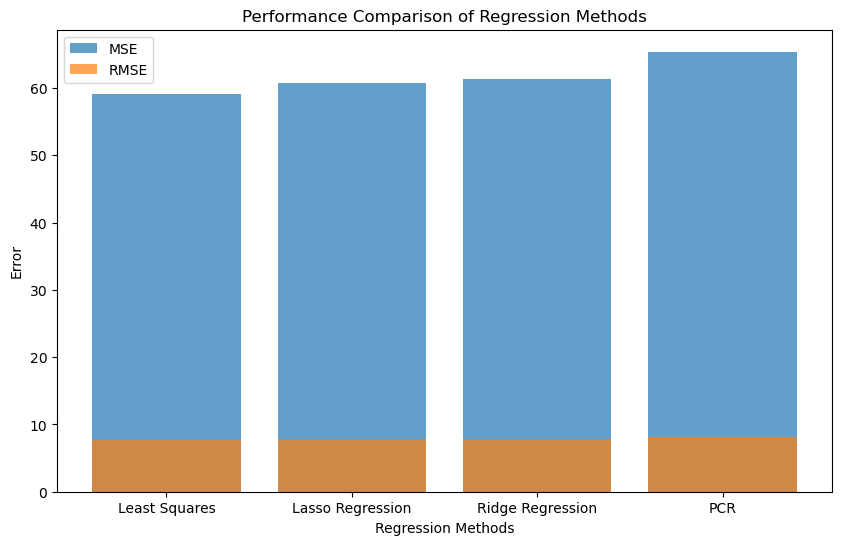

In [135]:
methods = ['Least Squares', 'Ridge Regression', 'Lasso Regression', 'PCR']
mse_values = [59.144929269707006, 61.26410431049417, 60.69464788290825, 65.3798926756243]
rmse_values = [7.690574053327034, 7.827138960724676, 7.790676984890867, 8.085783368086503]

plt.figure(figsize=(10, 6))

plt.bar([methods[i] for i in np.argsort(mse_values)], sorted(mse_values), alpha=0.7, label='MSE')
plt.bar([methods[i] for i in np.argsort(rmse_values)], sorted(rmse_values), alpha=0.7, label='RMSE')

plt.xlabel('Regression Methods')
plt.ylabel('Error')
plt.title('Performance Comparison of Regression Methods')
plt.legend()
plt.show()


#### Exercise 6.6.11 b

Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error.

__Answer__:

During fitting various models on  `Boston` dataset, the best method was Best Subset Selection method with fitting Linear Regression, it achieves the lowest MSE on the `Boston` dataset. Second algorithm with a regard to test RMSE and MSE was a Lasso Regression. All methods except Best Subset Selection, performed cross-validation with K-Fold where $K=5$. 

#### Exercise 6.6.12 c

Does your chosen model involve all of the features in the data set? Why or why not?

__Answer__:

- No, the models that I've chosen do not contain all the features. The reason might be that in fact, those features that are not present in the model (Lasso or Best Subset Selection), might not be associated with response variable $Y$.

In [136]:
best_features

(0, 2, 3, 5, 6, 7, 9, 11)

In [137]:
lasso.coef_

array([-0.00000000e+00,  1.58836493e+00, -8.29792341e-01,  2.20287423e+01,
        0.00000000e+00,  7.24709214e-02,  1.73895761e-02, -8.01065988e-02,
        1.33962958e-01,  5.58469090e-03, -1.67997844e-02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.57048799e-02,
        0.00000000e+00])

In [138]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   crim   R-squared (uncentered):                   0.528
Model:                            OLS   Adj. R-squared (uncentered):              0.517
Method:                 Least Squares   F-statistic:                              46.14
Date:                Wed, 15 Nov 2023   Prob (F-statistic):                    7.69e-73
Time:                        13:59:40   Log-Likelihood:                         -1657.4
No. Observations:                 506   AIC:                                      3339.
Df Residuals:                     494   BIC:                                      3389.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
zn             0.0450      0.019      2.391      0.017       0.008       0.082
indus         -0.0699      0.084     -0.835      0.404      -0.234       0.095
chas          -0.8568      1.187     -0.722      0.471      -3.188       1.475
nox           -4.0431      4.341     -0.931      0.352     -12.573       4.487
rm             1.2173      0.528      2.306      0.022       0.180       2.254
age           -0.0033      0.018     -0.182      0.856      -0.039       0.032
dis           -0.7762      0.256     -3.034      0.003      -1.279      -0.274
rad            0.5523      0.082      6.725      0.000       0.391       0.714
tax           -0.0023      0.005     -0.444      0.657      -0.012       0.008
ptratio       -0.0598      0.138     -0.433      0.665      -0.331       0.212
lstat          0.1966      0.070      2.814      0.005       0.059       0.334
medv          -0.1797      0.056     -3.194      0.001      -0.290      -0.069
==============================================================================
Omnibus:                      663.243   Durbin-Watson:                   1.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80159.962
Skew:                           6.580   Prob(JB):                         0.00
Kurtosis:                      63.240   Cond. No.                     6.77e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""